In [1]:
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
from pmdarima import auto_arima
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.pylab as plt

In [2]:
ETHdec_df = pd.read_csv('../../Resources/ETH/ETH-USD_Historical_Dec-11-2021.csv',index_col='Date', parse_dates= True)
ETHdec_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,7.982310,11.890900,7.982310,10.727500,10.727500,5.217485e+08
2017-02-01,10.741300,16.059401,10.551900,15.817200,15.817200,4.671668e+08
2017-03-01,15.847200,55.114700,15.558900,50.037300,50.037300,4.324810e+09
2017-04-01,50.033699,79.021202,40.901100,79.021202,79.021202,3.154320e+09
2017-05-01,79.321602,236.964996,73.086601,230.669006,230.669006,1.467995e+10


In [3]:
ETHdec_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [4]:
ETHdec_df = ETHdec_df.drop(columns=['Open','High','Low','Adj Close','Volume'])

In [5]:
ETHdec_df.head(10)

,Close
Date,
2017-01-01,10.727500
2017-02-01,15.817200
2017-03-01,50.037300
2017-04-01,79.021202
2017-05-01,230.669006
2017-06-01,294.915985
2017-07-01,203.871002
2017-08-01,383.041992
2017-09-01,301.464996


In [6]:
ETHdec_df.dtypes

Close    float64
dtype: object

In [7]:
#help(seasonal_decompose)

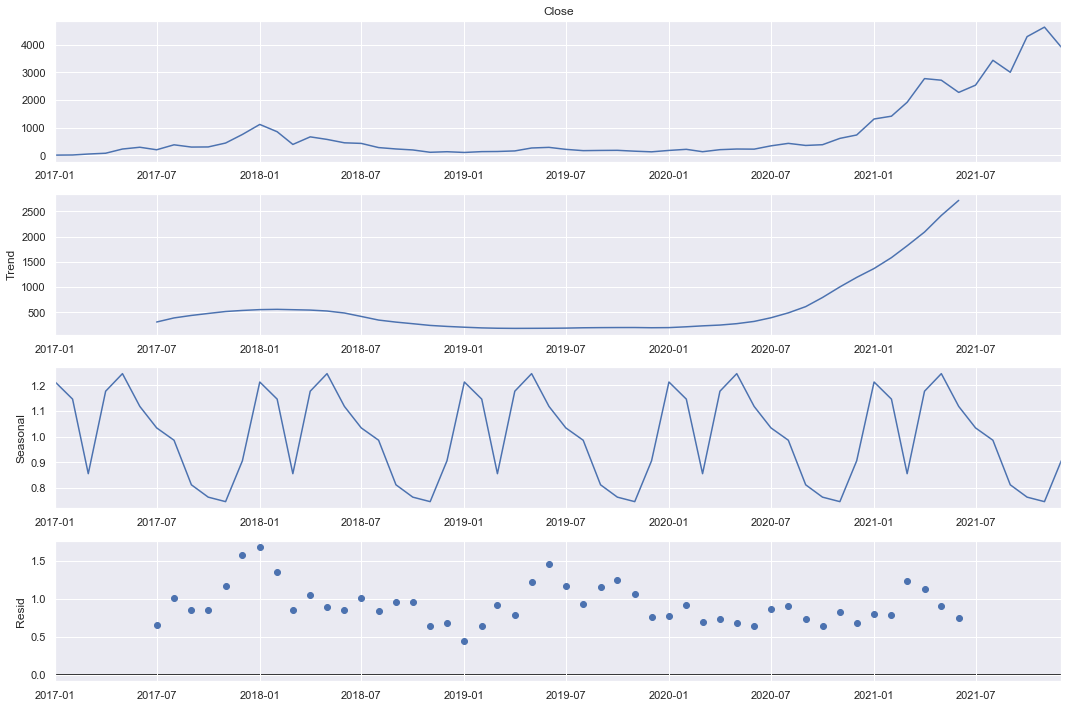

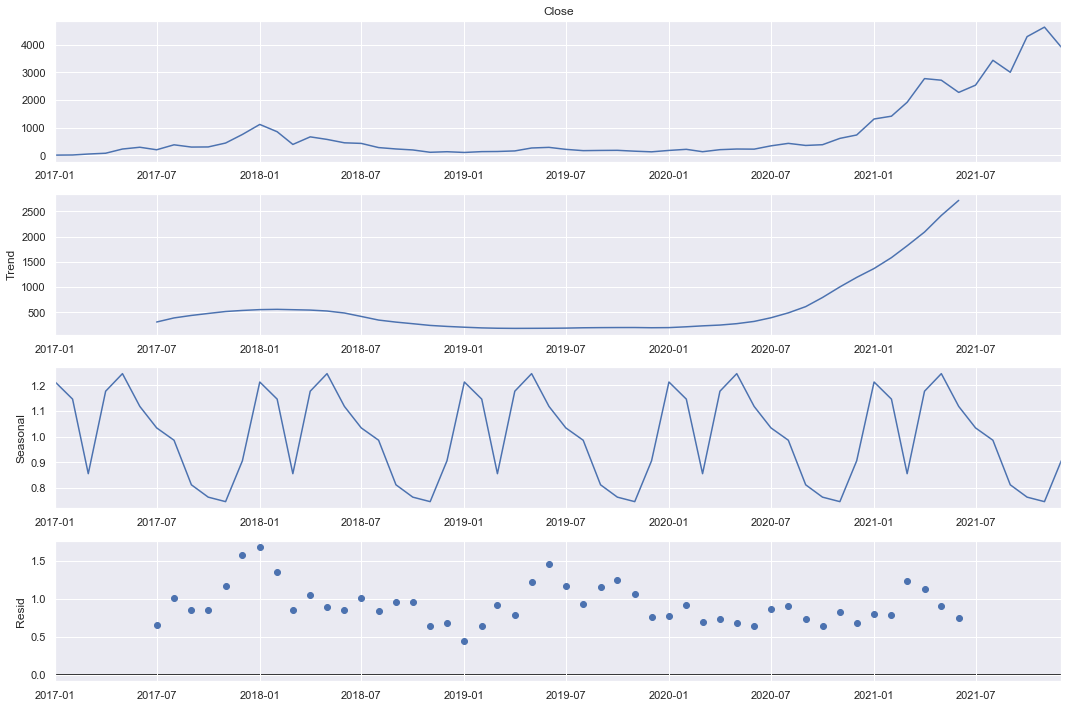

In [8]:
results = seasonal_decompose(ETHdec_df['Close'],model ='multiplicative',period=12)
plt.rcParams.update({'figure.figsize': (15,10)})
results.plot()

In [9]:
#Arima
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to ETH dataset
stepwise_fit = auto_arima(ETHdec_df['Close'], start_p = 0, start_q = 0,
max_p = 4, max_q = 4, m = 12,
start_P = 0, seasonal = True,
d = None, D = 1, trace = True,
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True, # we don't want convergence warnings
stepwise = True)# set to stepwise

# To print the summary
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=704.300, Time=0.09 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=703.521, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=697.376, Time=0.06 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=678.782, Time=0.11 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=677.765, Time=0.04 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=678.805, Time=0.08 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=680.755, Time=0.17 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=679.148, Time=0.06 sec
 ARIMA(0,2,2)(0,1,0)[12]             : AIC=678.203, Time=0.05 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=696.069, Time=0.02 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,1,0)[12]          
Total fit time: 2.291 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(0, 2, 1)x(0, 1, [], 12)   Log Likelihood                -336.882
Date:                             Sun, 12 Dec 2021   AIC                            677.765
Time:                                     21:44:02   BIC                            681.422
Sample:                                          0   HQIC                           679.135
                                              - 60                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9169      0.051    -18.155      0.000      -1.016      -0.818
sigma2      1.307e+05   1.93e+04      6.758      0.000    9.28e+04    1.69e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):                 8.96
Prob(Q):                              0.22   Prob(JB):                         0.01
Heteroskedasticity (H):               3.86   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Split data into train / test sets
train = ETHdec_df.iloc[:len(ETHdec_df)-12]
test = ETHdec_df.iloc[len(ETHdec_df)-12:] # set one year(12 months) for testing

# Fit a SARIMAX(0, 2, 2)x(0, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Close'],
order = (0, 2, 2),
seasonal_order =(0, 1, 1, 12))

result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                   48
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -224.155
Date:                              Sun, 12 Dec 2021   AIC                            456.311
Time:                                      21:44:02   BIC                            462.416
Sample:                                  01-01-2017   HQIC                           458.393
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8473      0.200     -4.227      0.000      -1.240      -0.454
ma.L2         -0.0126      0.179     -0.071      0.944      -0.363       0.337
ma.S.L12      -0.9992      0.264     -3.780      0.000      -1.517      -0.481
sigma2      1.949e+04   1.36e-05   1.44e+09      0.000    1.95e+04    1.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):                 2.82
Prob(Q):                              0.34   Prob(JB):                         0.24
Heteroskedasticity (H):               0.39   Skew:                             0.70
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.89e+25. Standard errors may be unstable.
"""

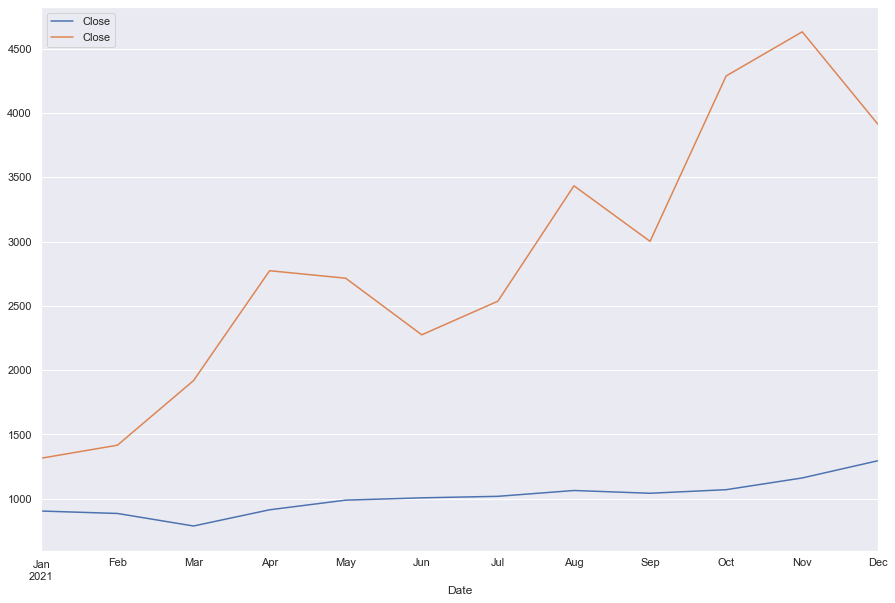

In [11]:
#Predictions of ARIMA Model agains the Test set
start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,typ = 'levels').rename("Close")

# plot predictions and actual values
predictions.plot(legend = True)
test['Close'].plot(legend = True)


In [12]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse(test["Close"], predictions)

2056.666794149729

In [13]:
# Calculate mean squared error
mean_squared_error(test["Close"], predictions)

4229878.302158124

Text(0, 0.5, 'Closing Amount (USD)')

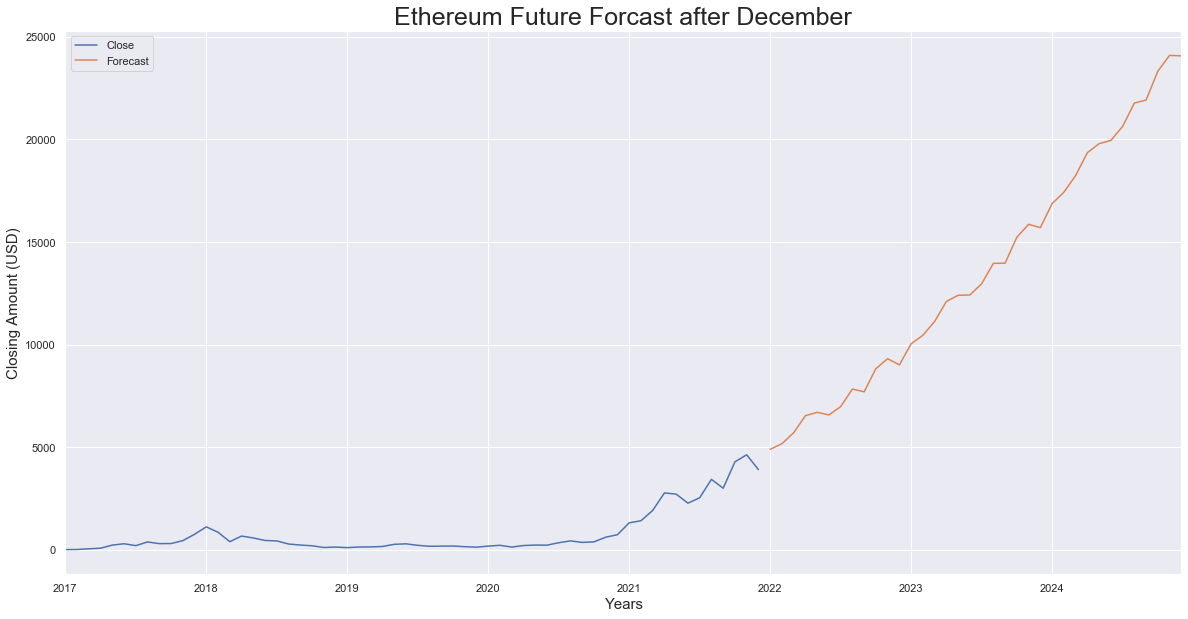

In [14]:
# Train the model on the full dataset
model = model = SARIMAX(ETHdec_df['Close'],order = (0, 2, 2),seasonal_order =(0, 1, 1, 12))
result = model.fit()

# Forecast for the next 3 years
forecast = result.predict(start = len(ETHdec_df),end = (len(ETHdec_df)-1) + 3 * 12,typ = 'levels').rename('Forecast')

# Plot the forecast values
ETHdec_df['Close'].plot(figsize = (20, 10), legend = True)
forecast.plot(legend = True)
plt.title("Ethereum Future Forcast after December", fontsize = 25)
plt.xlabel('Years',fontsize=15)
plt.ylabel('Closing Amount (USD)',fontsize=15)